In [1]:
# imports
from libs.ambiguity_functions import AASR  # function to be tested
from libs.spherical_earth_geometry_radar import *
from libs.radartools.farField import UniformAperture
from libs.design_functions import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# AASR function breakdown
the function takes as arguments
    - a RadarGeometry object
    - a UniformAperture object
    - the broadside incidence angle
    - the PRF
    - the processed Doppler bandwidth

internally it performs the following steps
- 81. finds the maximum azimuth angle, i.e. the horizon of the spherical earth (used as limit for the integration) given by the altitude and earth radius
- 91. converts the maximum angle to Doppler shift and computes th maximum sum index from that for the aasr equation
- 98. finds the denominator of the aasr sum by integrating the antenna pattern over the visible doppler range. the gain pattern is rerieved using the function "gain_from_doppler" which internally converts a doppler shift into ground coordinates and then spherical coordinates for the antenna pattern.
- 111. the numerator is found as the sum of positive and negative Doppler integrated  portions of the pattern


## Possible tests:
- vary the prf or the incidence angle for a doppler bandwidth fixed to the nominal one (use the same equation of unambiguous-imaging-design-analysis)
- rewrite the function internal loop plotting all the numerator/denominator contributions to understand whats happening. can plot both the patterns and the integrated patterns vs the index n.

# Design initialization


In [2]:
## System Parameters

# constants
c = 299792458

# radar parameters
dutycycle = 0.25  # duty cycle
h = 500e3  # height
wavelength = c / 10e9  # wavelength

# satellite speed
vs = orbital_speed(h)

# antenna size
Wa = 0.3  # antenna width in meters
La = 2  # antenna length in meters

## Objects
# Radar Geometry object
radar_geo = RadarGeometry()
radar_geo.set_rotation(30 * np.pi / 180, 0, 0)  # dummy looking angle, will be set in the analysis
radar_geo.set_initial_position(0, 0, h)
radar_geo.set_speed(vs)
# no need to set the radar rotation as this will be done inside the analysys function

# Uniform aperture antenna initialization
uniap = UniformAperture(La, Wa, c / wavelength)

# Bidimentional AASR map

In [3]:
# Map axis
ground_range = np.linspace(150, 170, 2) * 1000
prf = np.linspace(8000, 9000, 20)


In [4]:
# convert range to incidence angle
slant_range = range_ground_to_slant(ground_range)
ground_range, theta = range_slant_to_ground(slant_range)
aasr = np.zeros((len(ground_range), len(prf)))

# fill in the aasr matrix
for ii in tqdm(range(len(ground_range))):
    for jj in range(len(prf)):
        # pointing the radar to the incidence angle
        la = incidence_angle_to_looking_angle(theta[ii])
        radar_geo.set_rotation(la, 0, 0)
        bd = 2 * ground_speed(ground_range[ii], vs, h) / uniap.L * 0.5
        aasr[ii, jj] = AASR(radar_geo, uniap, theta[ii] * 180 / np.pi, prf[jj], bd, wavelength, pbaroff=True)


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\smen851\PycharmProjects\systemtradeoffs\libs\radartools\farField.py:149: RuntimeWarning: invalid value encountered in divide
  f = sin(kx * self.L / 2) / (kx * self.L / 2) * sin(ky * self.W / 2) / (ky * self.W / 2) * self.L * self.W
100%|██████████| 2/2 [01:08<00:00, 34.35s/it]


## serializing

In [5]:
# pickling


### SAVER

In [6]:
import os
import pickle

# Create a folder for the analysis results if it does not exist
if not os.path.exists('aasr-map'):
    os.makedirs('aasr-map')

# Save the results_list
with open('aasr-map/results_list.pk', 'wb') as f:
    pickle.dump(aasr, f)
# Save the x_coordinate
with open('aasr-map/x_coordinate.pk', 'wb') as f:
    pickle.dump(prf, f)
# Save the y_coordinate
with open('aasr-map/y_coordinate.pk', 'wb') as f:
    pickle.dump(ground_range, f)


### LOADER

In [7]:
import pickle
from IPython.display import Javascript

# Load the results_list
with open('aasr-map/results_list.pk', 'rb') as f:
    aasr = pickle.load(f)
# Load the x_coordinate
with open('aasr-map/x_coordinate.pk', 'rb') as f:
    prf = pickle.load(f)
# Load the y_coordinate
with open('aasr-map/y_coordinate.pk', 'rb') as f:
    ground_range = pickle.load(f)

# Plotting

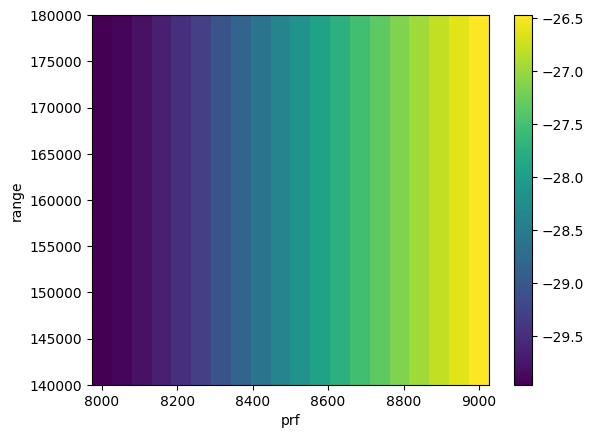

In [8]:

fig, ax = plt.subplots(1)
c = ax.pcolormesh(prf,ground_range, 10*np.log10(aasr))
ax.set_ylabel('range')
ax.set_xlabel('prf')
fig.colorbar(c)

In [9]:
print(aasr.argmax())
print(aasr.min())

19
0.001009391421051605


# EXPLODED AASR Function
plot some of the contributions of the aasr sum before integration

In [10]:
# ground range point
rg = 160e3
# prf point
prf = 8244
# Doppler bandwidth
Bd = 2 * ground_speed(rg, vs, h) / uniap.L * 0.5
# radar setup
rs = range_ground_to_slant(rg)
rg, incidence = range_slant_to_ground(rs)
la = incidence_angle_to_looking_angle(incidence)
radar_geo.set_rotation(la, 0, 0)


(array([ 1.,  0., -0.]),
 array([ 0.        , -0.95278692,  0.30363974]),
 array([ 0.        , -0.30363974, -0.95278692]))

In [11]:
from libs.ambiguity_functions import gain_from_doppler

max_order = 57 # number of positive and negative replicas


# 1. definition of the doppler axis
dop_ax = np.linspace(-Bd / 2, Bd / 2, 31)

# 2. redefinition of the axis as a meshgrid (for gain from doppler) # the pattern will be sampled at a constant phi (worst case)
D, I = np.meshgrid(dop_ax, incidence)

# 3. getting gain pattern for denominator
den_g, maxg = gain_from_doppler(D, I, radar_geo, uniap, wavelength, vs, h)
den_g /= maxg
# square and integrate over doppler
den = integrate.simps(den_g ** 2, D, axis=1)


In [12]:
# To open separate plot-windows outside the browser uncomment one of the following two lines
%matplotlib qt
fig, ax = plt.subplots(1)
ax.plot(D.flatten(), den_g.flatten()**2)
#ax.fill_between(D.flatten(), den_g.flatten()**2, np.zeros_like(den_g.flatten()))
print(den)

[3151.35689947]


In [13]:
from tqdm import tqdm
# loop
num = np.zeros_like(den)
for nn in tqdm(range(1, int(max_order + 1))):
    #D, I = np.meshgrid(dop_ax, incidence_angle * np.pi / 180)
    # positive n
    num_g, maxg = gain_from_doppler(D + nn * prf, I, radar_geo, uniap, wavelength, vs, h, aasr=True)
    num_g /= maxg
    num += integrate.simps(num_g ** 2, D, axis=1)
    ax.plot(D.flatten(), num_g.flatten(),'k')
    #ax.fill_between(D.flatten(), num_g.flatten()**2 , np.zeros_like(den_g.flatten()))
    # negative n
    num_g, maxg = gain_from_doppler(D - nn * prf, I, radar_geo, uniap, wavelength, vs, h, aasr=True)
    num_g /= maxg
    num += integrate.simps(num_g ** 2, D, axis=1)
    ax.plot(D.flatten(), num_g.flatten()**2,'k')
    if 1 in num_g.flatten()**2:
        print(nn)
    #ax.fill_between(D.flatten(), num_g.flatten()**2 , np.zeros_like(den_g.flatten()))
plt.show()

 98%|█████████▊| 56/57 [00:01<00:00, 30.90it/s]C:\Users\smen851\PycharmProjects\systemtradeoffs\libs\spherical_earth_geometry_radar.py:290: RuntimeWarning: invalid value encountered in sqrt
  arg = ((lambda_c ** 2 * doppler_mesh ** 2 + np.sqrt(
100%|██████████| 57/57 [00:01<00:00, 31.07it/s]

57


In [14]:
# maximum order calculation
re=6371e3
# azimuth circle radius
r0, rg = range_from_theta(incidence * 180 / np.pi, h)
costheta_e = ((re + h) ** 2 + re ** 2 - r0 ** 2) / (2 * (re + h) * re)
raz = re * costheta_e
d = r0 * cos(la)
# projected maximum slant range
l = np.sqrt((d + raz) ** 2 - raz ** 2)

# maximum azimuthal angle
costheta_a = (raz ** 2 + (raz + d) ** 2 - l ** 2) / (2 * raz * (raz + d))
theta_a = arccos(costheta_a)

cos_phimax = (-raz ** 2 + (raz + d) ** 2 + l ** 2) / (2 * l * (raz + d))
phimax = arccos(cos_phimax)

# then the max doppler shift is:
A = (re + h) ** 2 + re ** 2
B = 2 * (re + h) * re * costheta_e
v = vs / (re + h)

doppler_max = (B * v * sin(theta_a) / (wavelength * np.sqrt(A - B * cos(theta_a))))

# this maximum doppler corresponds to a sum order of
n = int(np.floor(doppler_max / prf))

In [15]:
n

57

# conclusion
the problem was the max oder n in the AASR sum, trying to sample the pattern over the orizon  causes a singularity (or probably a resampling of the pattern at broadside i.e. maximum directivity)